In [1]:
#-*- coding: utf-8 -*-

import tensorflow as tf
# dont display much info of tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any level you prefer

# limit gpu memory usage only as much as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        print("Setting memory growth to True for GPU: ", gpu)
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print("Physical GPUs: ", len(gpus), "Logical GPUs: ", len(logical_gpus))
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Concatenate, Add, AveragePooling2D, concatenate
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt


2024-01-09 18:16:50.478139: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 18:16:50.524685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 18:16:50.524724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 18:16:50.526448: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 18:16:50.535658: I tensorflow/core/platform/cpu_feature_guar

Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Physical GPUs:  1 Logical GPUs:  1


In [2]:

# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
y = np.load(y_path)
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
print("y shape: ", y.shape) # laser power and velocity

#feats = np.load(feats_path)
#print("feats shape: ", feats.shape)
y = y[:, 0] # only use laser power
print("y shape: ", y.shape)

# normalize y
y = y / np.max(y)

manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
y shape:  (9587, 2)
y shape:  (9587,)


In [3]:
# unique values in y
y_unique = np.unique(y)
print("unique values in y: ", y_unique)

# encode y as integers based on unique values
y_encoded = np.zeros(y.shape)
for i in range(len(y_unique)):
    y_encoded[y == y_unique[i]] = i
print("y encoded: ", y_encoded)
# change to int
y_encoded = y_encoded.astype(int)

# print typr of y_encoded
print("y encoded type: ", type(y_encoded[0]))

unique values in y:  [0.18181818 0.45454545 0.72727273 1.        ]
y encoded:  [0. 0. 0. ... 3. 3. 3.]
y encoded type:  <class 'numpy.int64'>


In [4]:
# crate pairs
def create_pairs(manta, xiris, y_encoded):
    # set seed
    np.random.seed(42)
        
    pairs = []
    labels = []
    
    # Getting the indices of each class
    numclasses = len(np.unique(y_encoded))
    idx = [np.where(y_encoded==i)[0] for i in range(numclasses)]

    for idxA in range(len(y_encoded)):
        # grab the current image and label belonging to the current iteration
        currentImage = manta[idxA]
        label = y_encoded[idxA]

        # randomly pick an image that belongs to the same class label
        idxB = np.random.choice(idx[label])
        posImage = xiris[idxB]

        # prepare a positive pair and update the images and labels lists, respectively
        pairs.append([currentImage, posImage])
        labels.append([0])

        # grab the indices for each of the class labels not equal to the current label
        negIdx = np.where(y_encoded != label)[0]
        
        # randomly pick an image corresponding to a label not equal to the current label
        negImage = xiris[np.random.choice(negIdx)]
        
        # prepare a negative pair of images and update our lists
        pairs.append([currentImage, negImage])
        labels.append([1])

        if idxA % 1000 == 0:
            print(f"Creating pairs for image {idxA}/{len(y_encoded)}, Completed {int(idxA/len(y_encoded)*100)}%")
    
    return np.array(pairs), np.array(labels)       


def create_triples(manta, xiris, y_encoded):
    # set seed
    np.random.seed(42)
        
    triples = []
    labels = []
    
    # Getting the indices of each class
    numclasses = len(np.unique(y_encoded))
    idx = [np.where(y_encoded==i)[0] for i in range(numclasses)]

    for idxA in range(len(y_encoded)):
        # grab the current image and label belonging to the current iteration
        currentImage = manta[idxA]
        label = y_encoded[idxA]

        # randomly pick an image that belongs to the same class label
        idxP = np.random.choice(idx[label])
        posImage = xiris[idxP]

        # grab the indices for each of the class labels not equal to the current label
        negIdx = np.where(y_encoded != label)[0]
        
        # randomly pick an image corresponding to a label not equal to the current label
        idxN = np.random.choice(negIdx)
        negImage = xiris[idxN]

        # combine triple
        triples.append([currentImage, posImage, negImage])
        # combine labels
        labels.append([y_encoded[idxA], y_encoded[idxP], y_encoded[idxN]])
        

        if idxA % 1000 == 0:
            print(f"Creating pairs for image {idxA}/{len(y_encoded)}, Completed {int(idxA/len(y_encoded)*100)}%")
    
    return np.array(triples), np.array(labels)

                                                                                             
# create pairs
triples, labels = create_triples(manta, xiris, y_encoded)
print("triples shape: ", triples.shape)

# split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(triples, labels, test_size=0.2, random_state=42)

# print shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Creating pairs for image 0/9587, Completed 0%
Creating pairs for image 1000/9587, Completed 10%
Creating pairs for image 2000/9587, Completed 20%
Creating pairs for image 3000/9587, Completed 31%
Creating pairs for image 4000/9587, Completed 41%
Creating pairs for image 5000/9587, Completed 52%
Creating pairs for image 6000/9587, Completed 62%
Creating pairs for image 7000/9587, Completed 73%
Creating pairs for image 8000/9587, Completed 83%
Creating pairs for image 9000/9587, Completed 93%
triples shape:  (9587, 3, 320, 320)
X_train shape: (7669, 3, 320, 320), y_train shape: (7669, 3)
X_test shape: (1918, 3, 320, 320), y_test shape: (1918, 3)


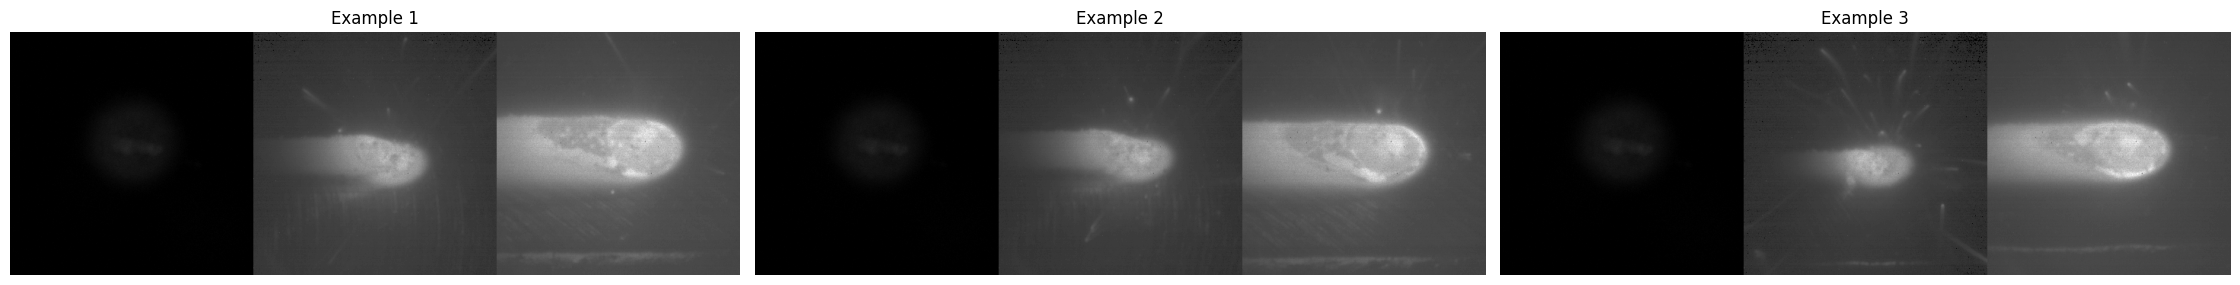

In [5]:
def visualize(triples, to_show=6, num_col=3):
    """Creates a plot of triples (Anchor, Positive, Negative).

    Arguments:
        triples: Numpy Array, of triples to visualize, having shape
               (Number of triples, 3, height, width).
        to_show: Int, number of examples to visualize (default is 6).
        num_col: Int, number of images in one row - (default is 3).

    Returns:
        None.
    """

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5 * num_col, 5 * num_row))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        anchor, positive, negative = triples[i]

        # Concatenate the images horizontally
        combined_image = tf.keras.layers.concatenate([anchor, positive, negative], axis=1)

        ax.imshow(combined_image, cmap="gray")
        ax.set_axis_off()
        ax.set_title(f"Example {i + 1}")

    plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

# visualize triples
visualize(triples, to_show=4, num_col=3)


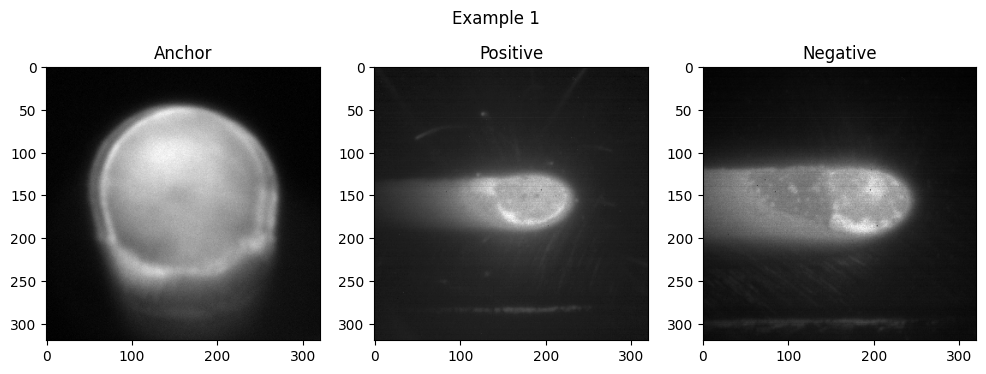

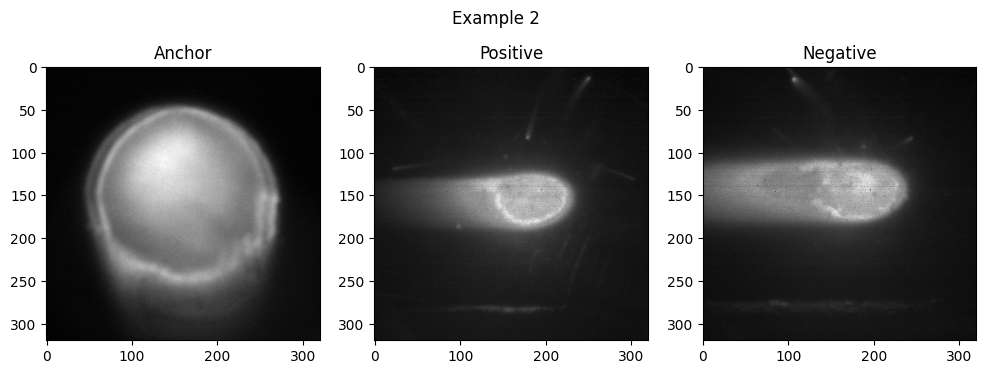

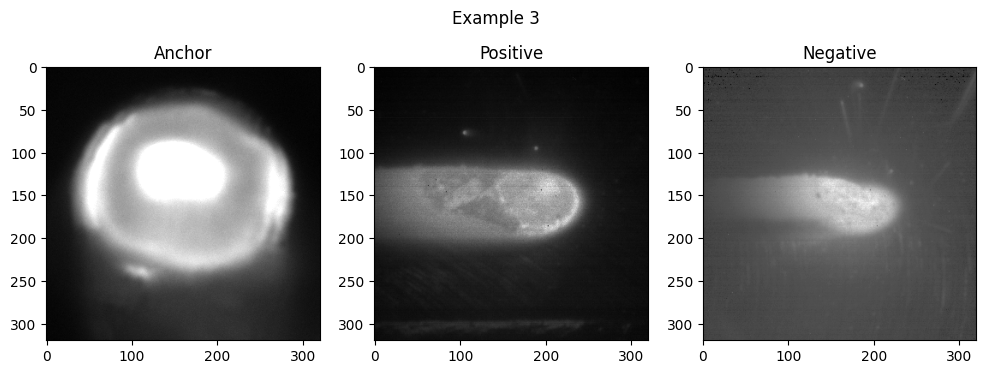

In [6]:
# Verify a few triples visually
num_samples_to_verify = 3

for i in range(num_samples_to_verify):
    sample_idx = np.random.randint(0, len(X_train))
    triple = X_train[sample_idx]
    
    # Extract images from the triple
    anchor, positive, negative = triple[0], triple[1], triple[2]

    # Display images with their corresponding labels
    plt.figure(figsize=(12, 4))
    
    # Anchor image
    plt.subplot(1, 3, 1)
    plt.imshow(anchor, cmap='gray')
    plt.title('Anchor')
    
    # Positive image
    plt.subplot(1, 3, 2)
    plt.imshow(positive, cmap='gray')
    plt.title('Positive')
    
    # Negative image
    plt.subplot(1, 3, 3)
    plt.imshow(negative, cmap='gray')
    plt.title('Negative')

    plt.suptitle('Example {}'.format(i + 1))
    plt.show()


In [7]:
def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    model = Model(inputs=inputs, outputs=x)
    return model

# add projection head
def add_projection_head(input_shape, encoder, embedding_dim):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)
    # add dense and dropout
    # add batch normalization
    #features = BatchNormalization()(features)
    #features = Dense(512, activation='relu')(features)
    #features = Dropout(0.5)(features)
    outputs = Dense(embedding_dim, activation='relu')(features) #outputs = Dense(embedding_dim, activation=None)(features)
    # add L2 normalization
    #outputs = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(outputs) # added 1
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum((anchor - positive) ** 2, axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum((anchor - negative) ** 2, axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = pos_dist - neg_dist + alpha
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss

In [13]:
class SiameseTripletModel(tf.keras.Model):
    def __init__(self, input_size, embedding_dim, learning_rate=0.0001, margin=1.0):
        super(SiameseTripletModel, self).__init__()
        self.input_size = input_size
        self.embedding_dim = embedding_dim
        self.margin = margin
        self.learning_rate = learning_rate

        self.encoder = self.create_encoder()
        self.siamese_model = self.build_siamese_model()

        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def create_encoder(self):
        # Implement your encoder creation logic here
        # For example, you can use the functions create_encoder and add_projection_head
        # Assume they are defined appropriately
        encoder = create_encoder(self.input_size)
        encoder_with_projection_head = add_projection_head(self.input_size, encoder, self.embedding_dim)
        return encoder_with_projection_head

    def triplet_loss(self, y_true, y_pred):
        anchor, positive, negative = y_pred[:, :self.embedding_dim], y_pred[:, self.embedding_dim:2*self.embedding_dim], y_pred[:, 2*self.embedding_dim:]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        triplet_loss = tf.maximum(pos_dist - neg_dist + self.margin, 0.0)
        return tf.reduce_mean(triplet_loss)

    def triplet_accuracy(self, y_true, y_pred):
        anchor, positive, negative = y_pred[:, :self.embedding_dim], y_pred[:, self.embedding_dim:2*self.embedding_dim], y_pred[:, 2*self.embedding_dim:]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        correct_predictions = tf.cast(tf.less(pos_dist, neg_dist), tf.float32)
        return tf.reduce_mean(correct_predictions)

    def cosine_similarity(self, y_true, y_pred):
        anchor, positive, negative = y_pred[:, :self.embedding_dim], y_pred[:, self.embedding_dim:2*self.embedding_dim], y_pred[:, 2*self.embedding_dim:]
        dot_product = tf.reduce_sum(anchor * positive, axis=-1)
        norm_anchor = tf.sqrt(tf.reduce_sum(tf.square(anchor), axis=-1))
        norm_positive = tf.sqrt(tf.reduce_sum(tf.square(positive), axis=-1))
        cosine_similarity = dot_product / (norm_anchor * norm_positive + K.epsilon())
        return cosine_similarity

    def build_siamese_model(self):
        A = Input(shape=self.input_size, dtype=tf.float32)
        P = Input(shape=self.input_size, dtype=tf.float32)
        N = Input(shape=self.input_size, dtype=tf.float32)

        A_encoded = self.encoder(A)
        P_encoded = self.encoder(P)
        N_encoded = self.encoder(N)

        merged_vector = concatenate([A_encoded, P_encoded, N_encoded], axis=-1)

        model = Model(inputs=[A, P, N], outputs=merged_vector)
        model.compile(loss=self.triplet_loss,
                      optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      metrics=[self.triplet_accuracy, self.cosine_similarity])
        return model

    def summary(self):
        self.siamese_model.summary()

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            y_pred = self.siamese_model(data)
            loss = self.triplet_loss(None, y_pred)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_model.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(zip(gradients, self.siamese_model.trainable_weights))

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        y_pred = self.siamese_model(data)
        loss = self.triplet_loss(None, y_pred)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

    def fit(self, X_train, y_train=None, batch_size=64, epochs=10, validation_split=0.2, callbacks=None):
        # Assuming X_train is a list containing triplets [anchor, positive, negative]
        history = self.siamese_model.fit(
            [X_train[:, 0], X_train[:, 1], X_train[:, 2]],
            np.zeros((len(X_train), 1)),  # dummy labels, as the loss function does not use y_train
            batch_size=batch_size,
            epochs=epochs,
            validation_split=validation_split,
            callbacks=callbacks
        )
        return history

    def evaluate(self, X_test, y_test=None, batch_size=64):
        # Assuming X_test is a list containing triplets [anchor, positive, negative]
        return self.siamese_model.evaluate([X_test[:, 0], X_test[:, 1], X_test[:, 2]],
                                          np.zeros((len(X_test), 1)),
                                          batch_size=batch_size)


In [14]:
input_size = (320, 320, 1)
embedding_dim = 128
learning_rate = 0.0001
margin = 1.0

siamese_model = SiameseTripletModel(input_size, embedding_dim)#, learning_rate, margin)

siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss=None,  # The loss is defined within the model
                      metrics=[siamese_model.triplet_accuracy, siamese_model.cosine_similarity])
siamese_model.summary()

siamese_model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, callbacks=None)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 input_15 (InputLayer)       [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_6 (Functional)        (None, 128)                  2492499   ['input_13[0][0]',            
                                                          2          'input_14[0][0]',      

2024-01-09 18:30:16.297743: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-09 18:30:16.528436: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-09 18:30:17.725755: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-09 18:30:20.548341: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f599fc6dcc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-09 18:30:20.548388: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-09 18:30:20.561036: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704825020.778482  496435 device_compiler.h:186] 

96/96 [==============================] - 26s 192ms/step - loss: 0.2938 - triplet_accuracy: 0.9138 - cosine_similarity: 0.9315 - val_loss: 0.2012 - val_triplet_accuracy: 0.9335 - val_cosine_similarity: 0.8666
Epoch 2/10
96/96 [==============================] - 9s 92ms/step - loss: 0.1721 - triplet_accuracy: 0.9488 - cosine_similarity: 0.8936 - val_loss: 0.1497 - val_triplet_accuracy: 0.9492 - val_cosine_similarity: 0.8284
Epoch 3/10
96/96 [==============================] - 9s 94ms/step - loss: 0.1075 - triplet_accuracy: 0.9686 - cosine_similarity: 0.8752 - val_loss: 0.1197 - val_triplet_accuracy: 0.9615 - val_cosine_similarity: 0.8813
Epoch 4/10
96/96 [==============================] - 9s 93ms/step - loss: 0.0854 - triplet_accuracy: 0.9731 - cosine_similarity: 0.8689 - val_loss: 0.0837 - val_triplet_accuracy: 0.9713 - val_cosine_similarity: 0.8644
Epoch 5/10
96/96 [==============================] - 9s 92ms/step - loss: 0.0729 - triplet_accuracy: 0.9790 - cosine_similarity: 0.8785 - val_